In [1]:
import numpy as np
from lattice2d_linear_env import Lattice2DLinearEnv

In [2]:
def policy_iteration(env, discount_factor=1.0, max_iter = 10000):
    """
    Policy Iteration Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI environment.
        discount_factor: Gamma discount factor.
        max_iter: Maximum iterations
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """

    def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
        """
        Evaluate a policy given an environment and a full description of the environment's dynamics.

        Args:
            policy: [S, A] shaped matrix representing the policy.
            env: OpenAI env. env.P represents the transition probabilities of the environment.
                env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
                env.nS is a number of states in the environment. 
                env.nA is a number of actions in the environment.
            theta: We stop evaluation once our value function change is less than theta for all states.
            discount_factor: Gamma discount factor.

        Returns:
            Vector of length env.nS representing the value function.
        """
        # Start with a random (all 0) value function
        V = np.zeros(env.nS)
        for i in range(max_iter):
            delta = 0
            # For each state, perform a "full backup"
            for s in range(env.nS - 3**(len(env.seq) - 2)):
                v = 0
                # Look at the possible next actions
                for a, action_prob in enumerate(policy[s]):
                    # For each action, look at the possible next states...
                    next_state, reward, done = env.P[s][a]
                    # Calculate the expected value
                    v += action_prob * (reward + discount_factor * V[next_state])
                # How much our value function changed (across any states)
                delta = max(delta, np.abs(v - V[s]))
                V[s] = v
            # Stop evaluating once our value function change is below a threshold
            if delta < theta:
                break
        return np.array(V)

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            next_state, reward, done = env.P[state][a]
            A[a] += reward + discount_factor * V[next_state]
        return A
    
    # Start of policy iteration
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    for i in range(max_iter):
        # Evaluate the current policy
        V = policy_eval(policy, env, discount_factor)
        
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        # For each state...
        for s in range(env.nS):
            # The best action we would take under the current policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = one_step_lookahead(s, V)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(env.nA)[best_a]
        
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable:
            return policy, V

In [3]:
def run_policy(env, policy):
    state = env.reset()
    curr = 0
    trajectory = ()
    action = 0
    next_state, reward, done, info = env.step(action)
    env.render()
    state=next_state
    for i in range(len(env.seq) - 2):
        direction = np.where(policy[curr] == 1.0)[0][0]
        action = (3 * action + direction) % 4
        next_state, reward, done, info = env.step(action)
        env.render()
        state=next_state
        trajectory += (direction,)
        curr = env.states_dic[trajectory]
        if done:
            print("Reward: {} | Actions: {}".format(reward, info['actions']))
            break

In [4]:
env = Lattice2DLinearEnv("HHPHPHHPPH")
policy, v = policy_iteration(env)

C:\Users\binyu\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Your agent was trapped! Ending the episode.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
v

array([4., 4., 3., ..., 0., 0., 0.])

In [6]:
policy

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

Reward: 4 | Actions: ['L', 'D', 'R', 'D', 'R', 'U', 'R', 'U', 'L']


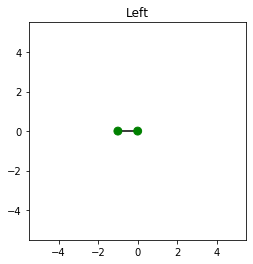

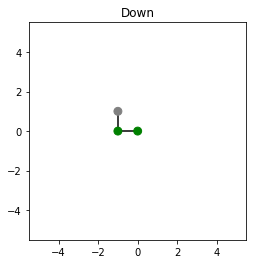

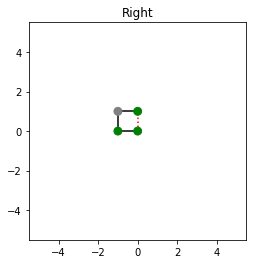

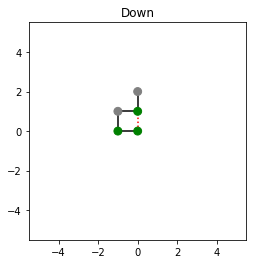

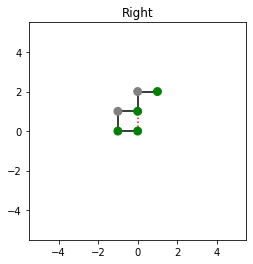

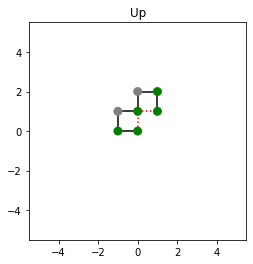

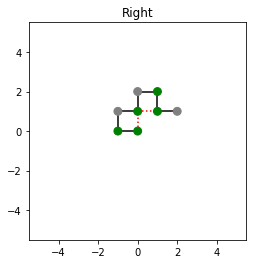

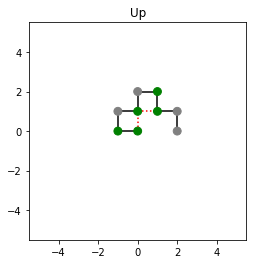

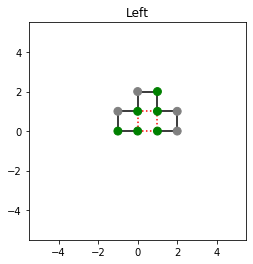

In [7]:
run_policy(env, policy)